In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:26 - loss: 0.0296 - STD: 2.1937e-04 - MAE: 0.1632

 2/74 [..............................] - ETA: 45s - loss: 0.0206 - STD: 2.1867e-04 - MAE: 0.1196 

 5/74 [=>............................] - ETA: 12s - loss: 0.0231 - STD: 2.1770e-04 - MAE: 0.1154

 6/74 [=>............................] - ETA: 10s - loss: 0.0215 - STD: 2.4601e-04 - MAE: 0.1070

 7/74 [=>............................] - ETA: 9s - loss: 0.0200 - STD: 2.8671e-04 - MAE: 0.1015 

 8/74 [==>...........................] - ETA: 8s - loss: 0.0192 - STD: 3.3243e-04 - MAE: 0.1009

 9/74 [==>...........................] - ETA: 7s - loss: 0.0190 - STD: 3.7678e-04 - MAE: 0.1027

10/74 [===>..........................] - ETA: 7s - loss: 0.0188 - STD: 4.1980e-04 - MAE: 0.1042

11/74 [===>..........................] - ETA: 7s - loss: 0.0184 - STD: 4.5690e-04 - MAE: 0.1038

12/74 [===>..........................] - ETA: 6s - loss: 0.0178 - STD: 4.8901e-04 - MAE: 0.1018

13/74 [====>.........................] - ETA: 6s - loss: 0.0173 - STD: 5.1682e-04 - MAE: 0.0989

14/74 [====>.........................] - ETA: 6s - loss: 0.0169 - STD: 5.3972e-04 - MAE: 0.0961

15/74 [=====>........................] - ETA: 5s - loss: 0.0167 - STD: 5.6014e-04 - MAE: 0.0937

16/74 [=====>........................] - ETA: 5s - loss: 0.0165 - STD: 5.7956e-04 - MAE: 0.0919

17/74 [=====>........................] - ETA: 5s - loss: 0.0164 - STD: 5.9963e-04 - MAE: 0.0902

18/74 [======>.......................] - ETA: 5s - loss: 0.0162 - STD: 6.2128e-04 - MAE: 0.0886

19/74 [======>.......................] - ETA: 5s - loss: 0.0160 - STD: 6.4543e-04 - MAE: 0.0870

20/74 [=======>......................] - ETA: 4s - loss: 0.0158 - STD: 6.7220e-04 - MAE: 0.0859

21/74 [=======>......................] - ETA: 4s - loss: 0.0156 - STD: 7.0113e-04 - MAE: 0.0852

22/74 [=======>......................] - ETA: 4s - loss: 0.0154 - STD: 7.3188e-04 - MAE: 0.0849

23/74 [========>.....................] - ETA: 4s - loss: 0.0153 - STD: 7.6454e-04 - MAE: 0.0850

24/74 [========>.....................] - ETA: 4s - loss: 0.0152 - STD: 7.9735e-04 - MAE: 0.0851

25/74 [=========>....................] - ETA: 4s - loss: 0.0151 - STD: 8.3087e-04 - MAE: 0.0852

26/74 [=========>....................] - ETA: 4s - loss: 0.0150 - STD: 8.6269e-04 - MAE: 0.0850

27/74 [=========>....................] - ETA: 3s - loss: 0.0149 - STD: 8.9423e-04 - MAE: 0.0846

28/74 [==========>...................] - ETA: 3s - loss: 0.0148 - STD: 9.2437e-04 - MAE: 0.0840

29/74 [==========>...................] - ETA: 3s - loss: 0.0147 - STD: 9.5427e-04 - MAE: 0.0834

30/74 [===========>..................] - ETA: 3s - loss: 0.0146 - STD: 9.8381e-04 - MAE: 0.0827

31/74 [===========>..................] - ETA: 3s - loss: 0.0145 - STD: 0.0010 - MAE: 0.0819    

32/74 [===========>..................] - ETA: 3s - loss: 0.0144 - STD: 0.0010 - MAE: 0.0813

33/74 [============>.................] - ETA: 3s - loss: 0.0143 - STD: 0.0011 - MAE: 0.0806

34/74 [============>.................] - ETA: 3s - loss: 0.0143 - STD: 0.0011 - MAE: 0.0801

35/74 [=============>................] - ETA: 3s - loss: 0.0142 - STD: 0.0012 - MAE: 0.0796

36/74 [=============>................] - ETA: 3s - loss: 0.0141 - STD: 0.0012 - MAE: 0.0793

37/74 [==============>...............] - ETA: 2s - loss: 0.0140 - STD: 0.0012 - MAE: 0.0792

38/74 [==============>...............] - ETA: 2s - loss: 0.0140 - STD: 0.0013 - MAE: 0.0791

39/74 [==============>...............] - ETA: 2s - loss: 0.0139 - STD: 0.0014 - MAE: 0.0790

40/74 [===============>..............] - ETA: 2s - loss: 0.0139 - STD: 0.0014 - MAE: 0.0789

41/74 [===============>..............] - ETA: 2s - loss: 0.0138 - STD: 0.0015 - MAE: 0.0788

42/74 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 0.0015 - MAE: 0.0786

43/74 [================>.............] - ETA: 2s - loss: 0.0137 - STD: 0.0016 - MAE: 0.0783

44/74 [================>.............] - ETA: 2s - loss: 0.0137 - STD: 0.0017 - MAE: 0.0781

45/74 [=================>............] - ETA: 2s - loss: 0.0136 - STD: 0.0017 - MAE: 0.0778

46/74 [=================>............] - ETA: 2s - loss: 0.0136 - STD: 0.0018 - MAE: 0.0774

47/74 [==================>...........] - ETA: 2s - loss: 0.0135 - STD: 0.0019 - MAE: 0.0771

48/74 [==================>...........] - ETA: 1s - loss: 0.0135 - STD: 0.0020 - MAE: 0.0768

49/74 [==================>...........] - ETA: 1s - loss: 0.0134 - STD: 0.0021 - MAE: 0.0766

50/74 [===================>..........] - ETA: 1s - loss: 0.0134 - STD: 0.0022 - MAE: 0.0764

51/74 [===================>..........] - ETA: 1s - loss: 0.0133 - STD: 0.0023 - MAE: 0.0762

52/74 [====================>.........] - ETA: 1s - loss: 0.0133 - STD: 0.0024 - MAE: 0.0760

53/74 [====================>.........] - ETA: 1s - loss: 0.0132 - STD: 0.0026 - MAE: 0.0759

54/74 [====================>.........] - ETA: 1s - loss: 0.0132 - STD: 0.0027 - MAE: 0.0758

55/74 [=====================>........] - ETA: 1s - loss: 0.0131 - STD: 0.0029 - MAE: 0.0756

56/74 [=====================>........] - ETA: 1s - loss: 0.0131 - STD: 0.0031 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0130 - STD: 0.0033 - MAE: 0.0751

58/74 [======================>.......] - ETA: 1s - loss: 0.0130 - STD: 0.0035 - MAE: 0.0749

59/74 [======================>.......] - ETA: 1s - loss: 0.0129 - STD: 0.0037 - MAE: 0.0746

60/74 [=======================>......] - ETA: 1s - loss: 0.0129 - STD: 0.0040 - MAE: 0.0744

61/74 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 0.0042 - MAE: 0.0741

62/74 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 0.0045 - MAE: 0.0739

63/74 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 0.0049 - MAE: 0.0737

64/74 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 0.0053 - MAE: 0.0735

65/74 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 0.0057 - MAE: 0.0733

66/74 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0062 - MAE: 0.0730

67/74 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0066 - MAE: 0.0727

68/74 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0072 - MAE: 0.0725

69/74 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 0.0077 - MAE: 0.0721

70/74 [===========================>..] - ETA: 0s - loss: 0.0122 - STD: 0.0083 - MAE: 0.0718

71/74 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 0.0090 - MAE: 0.0715

72/74 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 0.0098 - MAE: 0.0713

73/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 0.0105 - MAE: 0.0710

74/74 [==============================] - ETA: 0s - loss: 0.0119 - STD: 0.0113 - MAE: 0.0707

74/74 [==============================] - 7s 83ms/step - loss: 0.0119 - STD: 0.0113 - MAE: 0.0707 - val_loss: 0.0057 - val_STD: 0.0464 - val_MAE: 0.0459


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0056 - STD: 0.0699 - MAE: 0.0489

 2/74 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0713 - MAE: 0.0479

 3/74 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0734 - MAE: 0.0474

 4/74 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0750 - MAE: 0.0468

 5/74 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0464

 6/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0459

 7/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0769 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0773 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0780 - MAE: 0.0446

10/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0443

11/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0794 - MAE: 0.0439

12/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0800 - MAE: 0.0436

13/74 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0802 - MAE: 0.0431

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0808 - MAE: 0.0428

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0815 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0822 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0829 - MAE: 0.0420

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0834 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0838 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0843 - MAE: 0.0412

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0849 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0854 - MAE: 0.0409

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0858 - MAE: 0.0407

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0861 - MAE: 0.0405

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0864 - MAE: 0.0404

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0867 - MAE: 0.0402

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0870 - MAE: 0.0401

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0875 - MAE: 0.0400

29/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0877 - MAE: 0.0399

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0879 - MAE: 0.0397

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0883 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0886 - MAE: 0.0395

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0889 - MAE: 0.0394

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0891 - MAE: 0.0393

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0893 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0895 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0896 - MAE: 0.0389

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0898 - MAE: 0.0388

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0900 - MAE: 0.0387

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0901 - MAE: 0.0386

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0385

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0384

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0383

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0908 - MAE: 0.0382

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0908 - MAE: 0.0382

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0381

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0380

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0379

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0379

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0378

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0912 - MAE: 0.0377

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0913 - MAE: 0.0377

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0914 - MAE: 0.0376

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0915 - MAE: 0.0376

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0916 - MAE: 0.0375

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0375

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0374

59/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0374

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0373

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0373

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0372

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0371

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0921 - MAE: 0.0371

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0370

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0370

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0369

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0369

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0369

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0368

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0368

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0926 - MAE: 0.0367

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0926 - MAE: 0.0367

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0926 - MAE: 0.0366

74/74 [==============================] - 5s 71ms/step - loss: 0.0031 - STD: 0.0926 - MAE: 0.0366 - val_loss: 0.0029 - val_STD: 0.0656 - val_MAE: 0.0328


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0991 - MAE: 0.0343

 2/74 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0989 - MAE: 0.0338

 3/74 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0974 - MAE: 0.0339

 4/74 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0336

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0337

 6/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0335

 7/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0975 - MAE: 0.0335

 8/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0973 - MAE: 0.0334

 9/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0971 - MAE: 0.0335

10/74 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0334

11/74 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0333

12/74 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0333

13/74 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0333

14/74 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0333

15/74 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0332

16/74 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0332

17/74 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0332

18/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0332

19/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0331

20/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0331

21/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0331

22/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

23/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0330

24/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

25/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0330

26/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0330

28/74 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0329

29/74 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0329

30/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

31/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

32/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0329

33/74 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0328

34/74 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0328

35/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0328

36/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0328

37/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0328

38/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0328

39/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0328

40/74 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0328

41/74 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0328

42/74 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0327

43/74 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

44/74 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0327

45/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

46/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

47/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0327

48/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

49/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

50/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

51/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

52/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0327

53/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

54/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

55/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

56/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

57/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

58/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

59/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

60/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0326

63/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0326

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0326

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0325

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

68/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

69/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0324

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0324

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0324

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0324

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0324

74/74 [==============================] - 5s 73ms/step - loss: 0.0024 - STD: 0.0970 - MAE: 0.0324 - val_loss: 0.0029 - val_STD: 0.0680 - val_MAE: 0.0312


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.0932 - MAE: 0.0312

 2/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0964 - MAE: 0.0311

 3/74 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0962 - MAE: 0.0309

 4/74 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0964 - MAE: 0.0308

 5/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0970 - MAE: 0.0308

 6/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0970 - MAE: 0.0307

 7/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0969 - MAE: 0.0306

 8/74 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0968 - MAE: 0.0306

 9/74 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0307

10/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0970 - MAE: 0.0307

11/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0307

12/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0307

13/74 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0970 - MAE: 0.0307

14/74 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0307

15/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0307

16/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0308

17/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0308

18/74 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0309

19/74 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0310

20/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0309

21/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0311

22/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

23/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0311

24/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

25/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0312

26/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

27/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

28/74 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

29/74 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0313

30/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0312

31/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0312

32/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0312

33/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0312

34/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0312

35/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0312

36/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0312

37/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311

38/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311

39/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311

40/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311

41/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0311

42/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0311

43/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0310

44/74 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

45/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

46/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

47/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

48/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

49/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0309

51/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0309

52/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0309

53/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0309

54/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0309

55/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0308

56/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0308

57/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0308

58/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0308

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0308

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0307

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0307

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0307

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0307

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0307

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0307

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0307

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0307

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0307

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0306

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0306

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0306

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306

74/74 [==============================] - 5s 71ms/step - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306 - val_loss: 0.0028 - val_STD: 0.0713 - val_MAE: 0.0314


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0301

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0984 - MAE: 0.0296

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0296

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0298

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0299

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0300

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0300

 8/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0300

 9/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0302

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0301

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0301

12/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0301

13/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0301

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0300

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0301

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0301

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0300

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0300

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0300

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0299

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

26/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

27/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

28/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

39/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

40/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

41/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

42/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

43/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

44/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

45/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

46/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

47/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

48/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

49/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

50/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

51/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

52/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

53/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

54/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

55/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

56/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

57/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

58/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

59/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0298

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0300

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0300

63/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0300

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0300

65/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0300

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0300

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0300

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0300

69/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0300

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0300

71/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0300

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0300

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0300

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

74/74 [==============================] - 5s 69ms/step - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299 - val_loss: 0.0028 - val_STD: 0.0716 - val_MAE: 0.0308


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0289

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0984 - MAE: 0.0289

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0987 - MAE: 0.0288

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0290

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0290

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0290

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0290

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0291

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0291

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0291

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0290

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0290

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0290

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0290

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0290

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0290

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0290

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0289

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0289

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0289

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0290

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0289

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0290

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0291

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0291

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0294

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

44/74 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

59/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

74/74 [==============================] - 5s 71ms/step - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292 - val_loss: 0.0027 - val_STD: 0.0739 - val_MAE: 0.0309


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0291

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0289

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0290

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0291

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0290

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0291

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0291

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0291

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0291

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0291

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0291

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0290

14/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0289

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0289

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0289

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0288

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0288

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0287

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0287

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0290

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0291

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0292

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

44/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

45/74 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0293

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0293

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

59/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0293

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0292

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0292

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0291

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0291

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0291

74/74 [==============================] - 5s 72ms/step - loss: 0.0020 - STD: 0.0999 - MAE: 0.0291 - val_loss: 0.0027 - val_STD: 0.0721 - val_MAE: 0.0307


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0285

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0989 - MAE: 0.0286

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0977 - MAE: 0.0282

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0986 - MAE: 0.0287

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0981 - MAE: 0.0290

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0292

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0293

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0292

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0294

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0293

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0293

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0293

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0292

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

29/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0292

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

44/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0291

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0291

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0292

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0291

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289 - val_loss: 0.0030 - val_STD: 0.0715 - val_MAE: 0.0317


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.0971 - MAE: 0.0288

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0290

 3/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0990 - MAE: 0.0286

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0978 - MAE: 0.0286

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0290

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0987 - MAE: 0.0290

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0288

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0288

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0287

15/74 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0287

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0286

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0286

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

74/74 [==============================] - 5s 72ms/step - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287 - val_loss: 0.0026 - val_STD: 0.0764 - val_MAE: 0.0318


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0298

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0290

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0292

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0296

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0295

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0292

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0293

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0293

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0294

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0291

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0291

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0290

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286 - val_loss: 0.0025 - val_STD: 0.0757 - val_MAE: 0.0315


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0294

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0286

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0285

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0286

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0287

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0287

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0287

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0287

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0286

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282 - val_loss: 0.0025 - val_STD: 0.0750 - val_MAE: 0.0302


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0278

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0283

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0283

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0283

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0282

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0287

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0288

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0287

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0286

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0286

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

15/74 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0286

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0286

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0286

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

74/74 [==============================] - 5s 71ms/step - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285 - val_loss: 0.0026 - val_STD: 0.0739 - val_MAE: 0.0298


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0979 - MAE: 0.0273

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0995 - MAE: 0.0275

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0275

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0992 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0278

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0278

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0278

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0277

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0278

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0278

15/74 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0278

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

74/74 [==============================] - 5s 67ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283 - val_loss: 0.0025 - val_STD: 0.0762 - val_MAE: 0.0309


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0290

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0986 - MAE: 0.0288

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0287

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0286

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0287

 7/74 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0286

 8/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0286

10/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0285

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0283

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0283

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0282

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

24/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0282

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

40/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

74/74 [==============================] - 5s 61ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280 - val_loss: 0.0025 - val_STD: 0.0758 - val_MAE: 0.0301


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.0979 - MAE: 0.0278

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

 7/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

 8/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

 9/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

10/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

22/74 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

23/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

24/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

40/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - 5s 61ms/step - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280 - val_loss: 0.0030 - val_STD: 0.0707 - val_MAE: 0.0322


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0299

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0293

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0288

 5/74 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0289

 6/74 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

 7/74 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

 8/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0287

 9/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0286

10/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0284

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0283

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0281

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

23/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

24/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

40/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

74/74 [==============================] - 5s 61ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280 - val_loss: 0.0025 - val_STD: 0.0781 - val_MAE: 0.0311


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0286

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0281

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0277

 8/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0275

10/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0274

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0274

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

23/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

24/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0275

25/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

26/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

40/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

74/74 [==============================] - 5s 61ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285 - val_loss: 0.0025 - val_STD: 0.0732 - val_MAE: 0.0293


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.0976 - MAE: 0.0264

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0955 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0995 - MAE: 0.0280

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0279

 5/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0280

 6/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0278

 7/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.0995 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0277

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

21/74 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

22/74 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

23/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

24/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

39/74 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

40/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

74/74 [==============================] - 5s 61ms/step - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276 - val_loss: 0.0025 - val_STD: 0.0771 - val_MAE: 0.0307


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0282

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0276

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

 6/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

 7/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0273

10/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0273

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

22/74 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

23/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

24/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

25/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

26/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

40/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

41/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

74/74 [==============================] - 5s 62ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274 - val_loss: 0.0025 - val_STD: 0.0758 - val_MAE: 0.0297


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0266

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0274

 4/74 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0273

 5/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0273

 6/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0272

 7/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0273

10/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0274

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0273

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0273

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

22/74 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

23/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

24/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

25/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

26/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

40/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

41/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

74/74 [==============================] - 5s 65ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275 - val_loss: 0.0027 - val_STD: 0.0729 - val_MAE: 0.0302


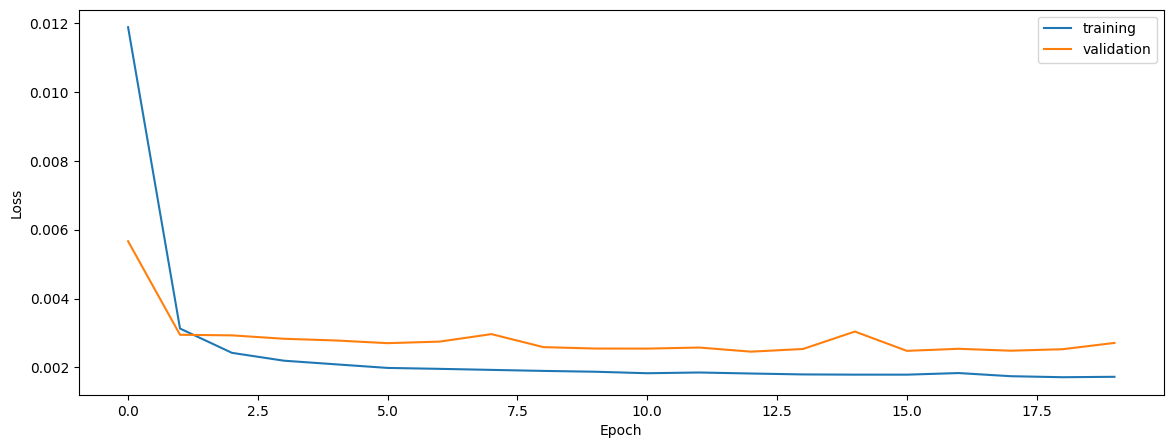

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


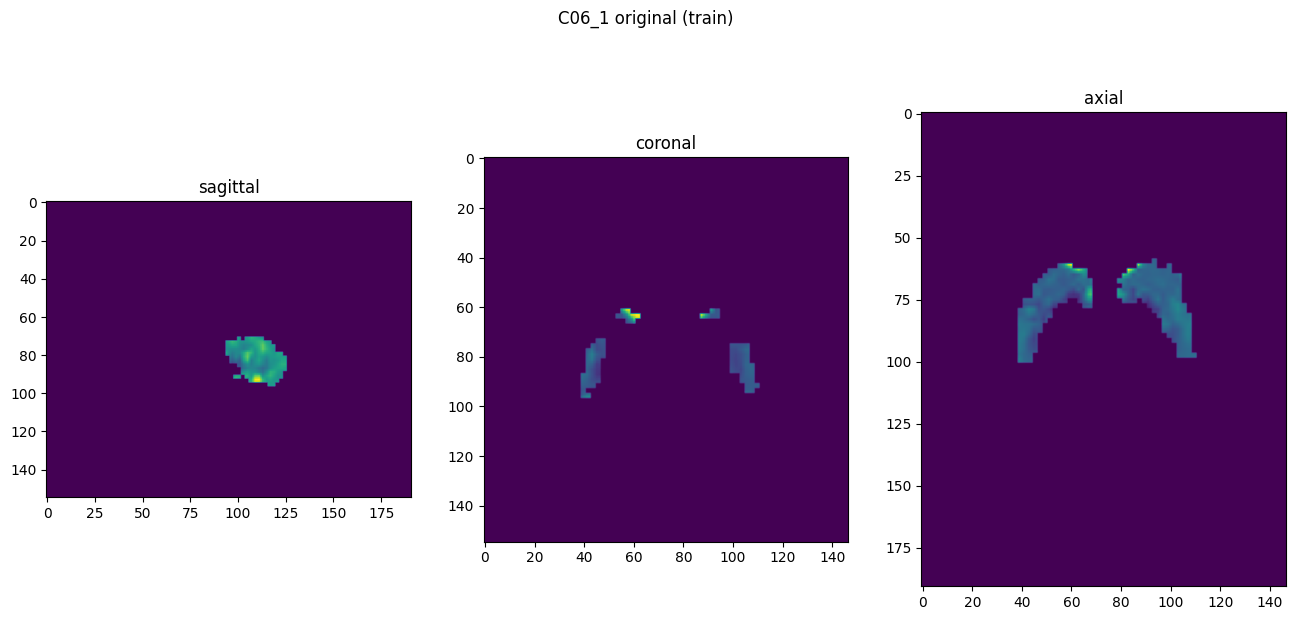

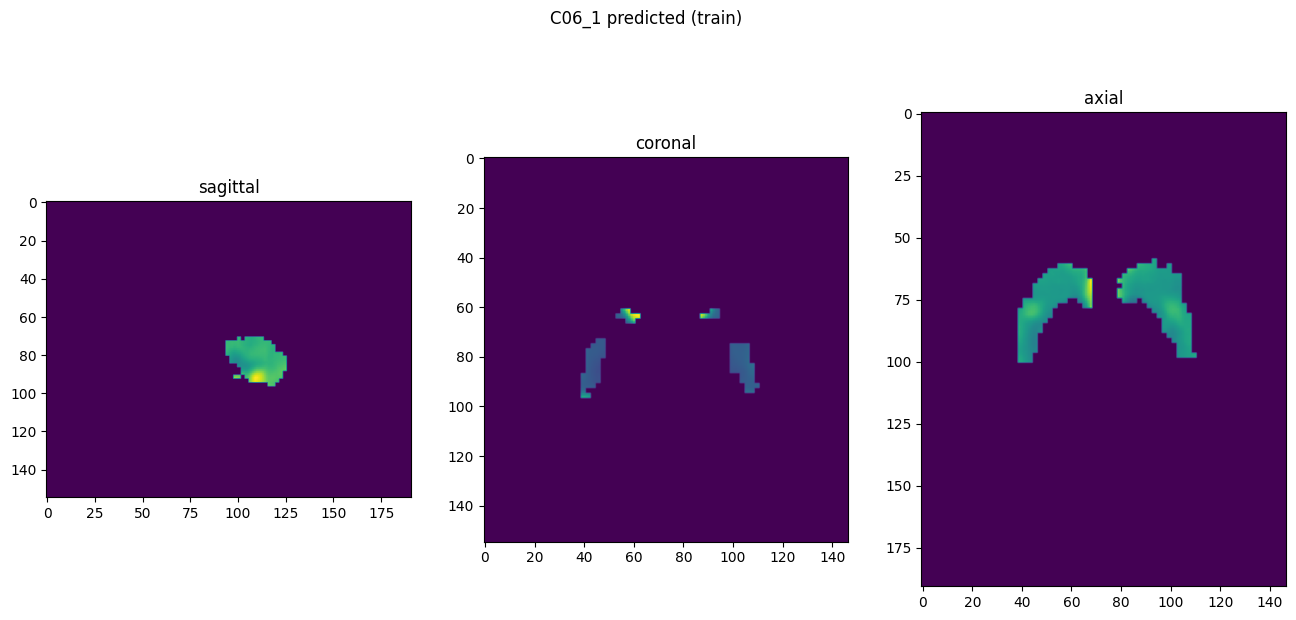

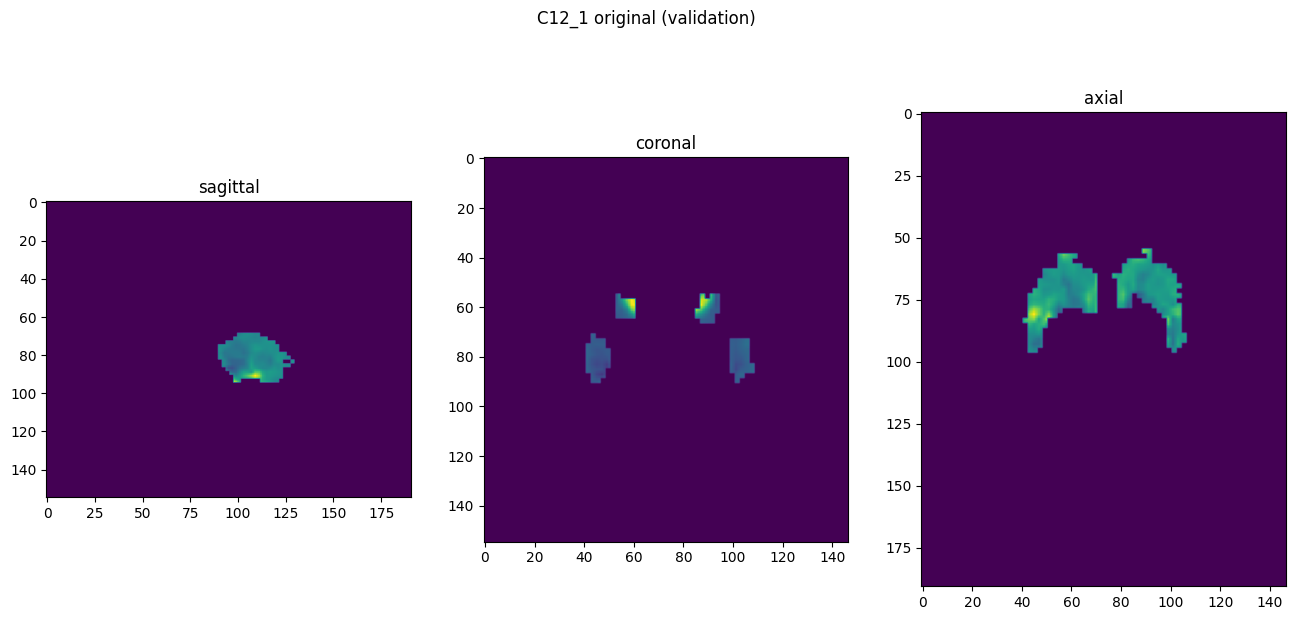

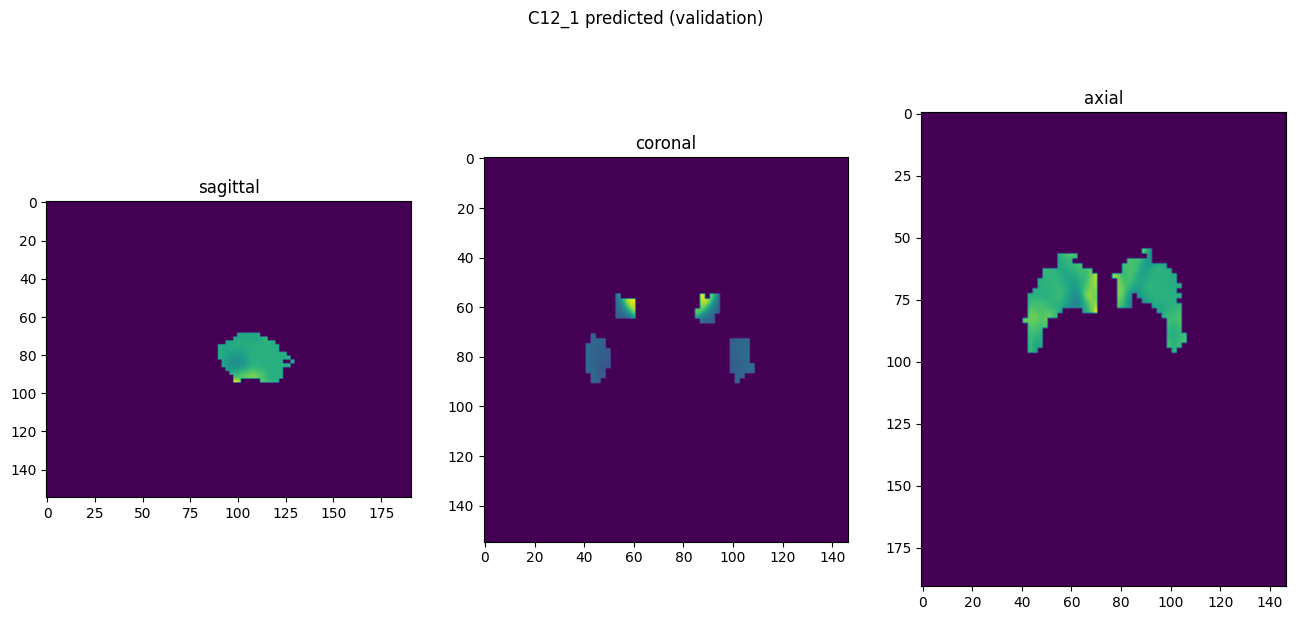

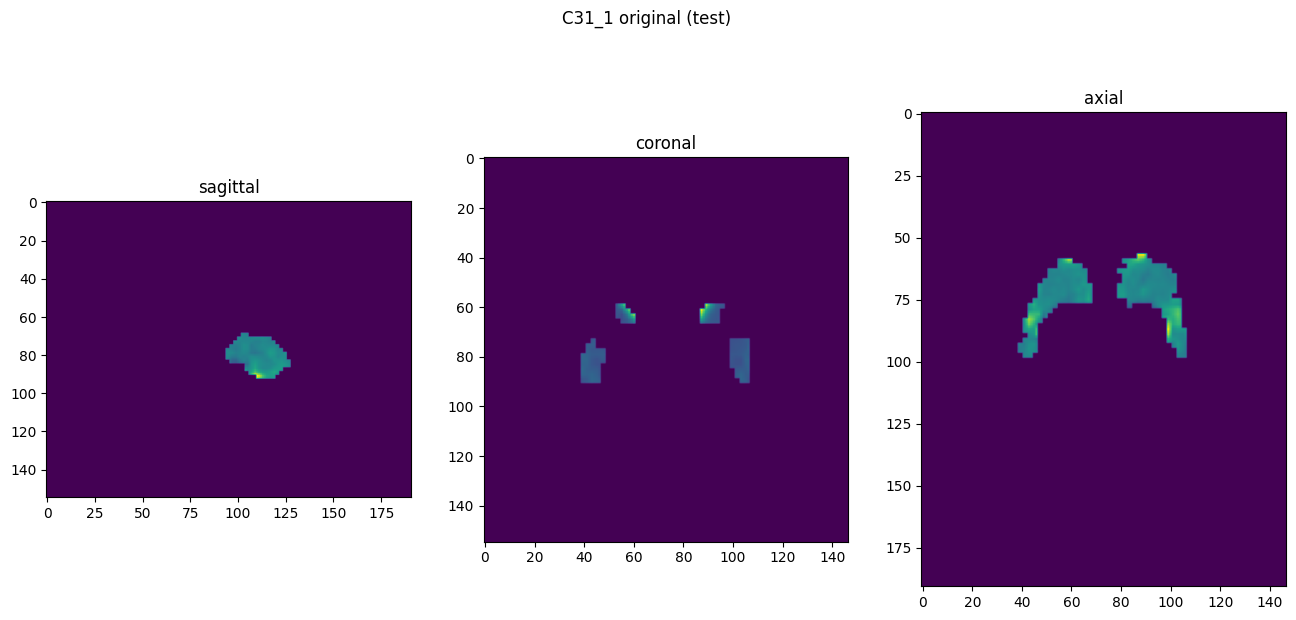

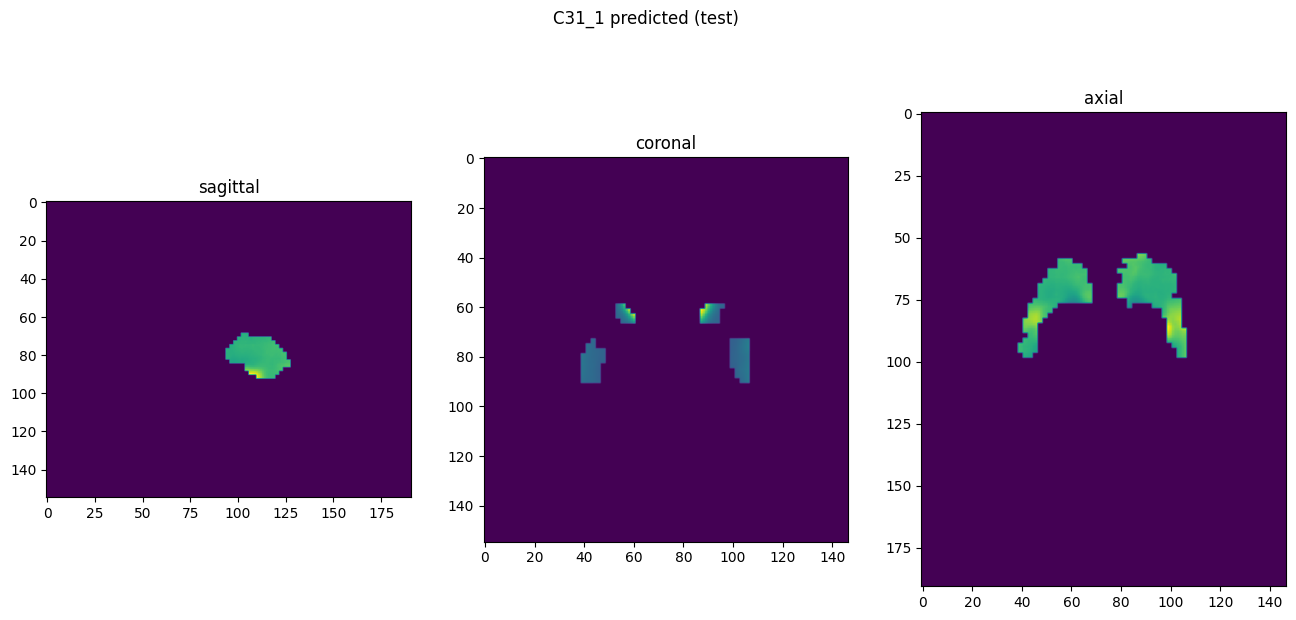

In [10]:
showResults(model, gen, threshold=None, background=False)